In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install librosa tensorflow numpy pandas scikit-learn matplotlib

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def extract_mfcc_2d(file_path, n_mfcc=40, segment_duration=3, overlap=0.5, n_fft=2048, hop_length=512):
    audio, sr = librosa.load(file_path, sr=None)
    segment_samples = int(segment_duration * sr)
    step_samples = int(segment_samples * (1 - overlap))
    mfcc_features = []

    for start in range(0, len(audio) - segment_samples + 1, step_samples):
        segment = audio[start:start + segment_samples]
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T  # transpose so shape is (time_steps, n_mfcc)
        mfcc_features.append(mfcc)

    return mfcc_features

# Load metadata
metadata = pd.read_csv("/content/drive/MyDrive/Data/features_30_sec.csv")
genres = metadata['label'].unique()

X, y = [], []
for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Extracting MFCCs"):
    file_path = os.path.join("/content/drive/MyDrive/Data/genres_original", row['label'], row['filename'])
    if os.path.exists(file_path):
        mfcc_segments = extract_mfcc_2d(file_path)
        X.extend(mfcc_segments)
        y.extend([row['label']] * len(mfcc_segments))
    else:
        print("File NOT found:", file_path)

Extracting MFCCs:  55%|█████▌    | 554/1000 [06:44<04:11,  1.78it/s]

File NOT found: /content/drive/MyDrive/Data/genres_original/jazz/jazz.00054.wav


Extracting MFCCs: 100%|██████████| 1000/1000 [11:53<00:00,  1.40it/s]


In [ ]:
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Data shape: (18972, 130, 40), Labels shape: (18972,)


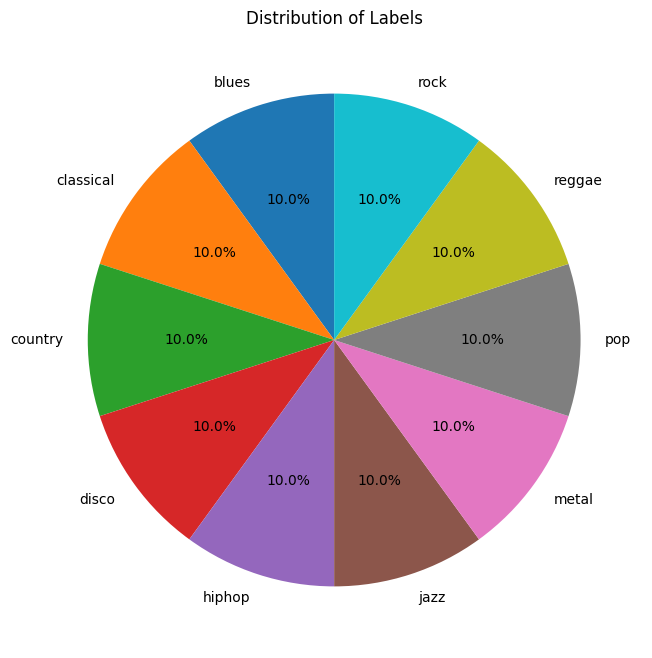

In [ ]:
value_counts = metadata['label'].value_counts()
labels = value_counts.index
sizes = value_counts.values
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Labels")
plt.show()

In [ ]:
# Add channel dimension for CNN: (samples, height, width, channels)
if len(X.shape) == 3:
  X = X[..., np.newaxis]  # shape: (18972, 130, 40, 1)
X.shape

(18972, 130, 40, 1)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, LSTM, Reshape
from tensorflow.keras.models import Model

def build_edl_model(input_shape, num_classes):
  inputs = Input(shape=(130, 40, 1))
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Reshape((x.shape[1], -1))(x)  # Flatten spatial dims, keep time
  x = LSTM(64)(x)
  x = Dropout(0.5)(x)
  evidence = Dense(num_classes, activation='softplus')(x)
  return Model(inputs, outputs=evidence)

In [ ]:
import tensorflow as tf
import numpy as np

def kl_dirichlet(alpha, num_classes):
    # alpha shape: (batch, num_classes)
    beta = tf.ones([1, num_classes], dtype=tf.float32)  # prior Dirichlet
    S_alpha = tf.reduce_sum(alpha, axis=1, keepdims=True)
    S_beta = tf.reduce_sum(beta, axis=1, keepdims=True)

    lnB_alpha = tf.math.lgamma(S_alpha) - tf.reduce_sum(tf.math.lgamma(alpha), axis=1, keepdims=True)
    lnB_beta = tf.math.lgamma(S_beta) - tf.reduce_sum(tf.math.lgamma(beta), axis=1, keepdims=True)

    digamma_alpha = tf.math.digamma(alpha)
    digamma_S_alpha = tf.math.digamma(S_alpha)

    kl = tf.reduce_sum((alpha - beta) * (digamma_alpha - digamma_S_alpha), axis=1, keepdims=True) + lnB_alpha - lnB_beta
    return kl  # shape (batch, 1)

def edl_loss(true, evidence, coeff=1.0):
    if len(true.shape) > 1 and true.shape[1] > 1:
        true = tf.argmax(true, axis=1)
    true = tf.cast(true, tf.int32)
    epsilon = 1e-8
    # Use standard alpha = evidence + 1
    alpha = evidence + 1.0
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    true_one_hot = tf.one_hot(true, depth=alpha.shape[1])
    loglikelihood = tf.reduce_sum(
        true_one_hot * (tf.math.log(alpha + epsilon) - tf.math.log(S + epsilon)), axis=1
    )
    kld = kl_dirichlet(alpha, num_classes=alpha.shape[1])
    return tf.reduce_mean(-loglikelihood + coeff * kld)

def edl_accuracy(y_true, evidence):
    if len(y_true.shape) > 1:
        y_true = tf.argmax(y_true, axis=1)
    alpha = evidence + 1
    probs = alpha / tf.reduce_sum(alpha, axis=1, keepdims=True)
    preds = tf.argmax(probs, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(preds, tf.cast(y_true, tf.int64)), tf.float32))

# Make sure your labels are integer encoded, not one-hot
print("Sample y_train before split:", y_encoded)

Sample y_train before split: [0 0 0 ... 9 9 9]


In [ ]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

input_shape = X_train.shape[1:]
num_classes = len(genres)

model = build_edl_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss=lambda y, ev: edl_loss(y, ev, coeff=1e-2),
    metrics=[edl_accuracy]
)
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 130, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 130, 40, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 65, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 65, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       180,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,450 (708.79 KB)

 Trainable params: 181,450 (708.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 98s 247ms/step - edl_accuracy: 0.2384 - loss: 2.1775 - val_edl_accuracy: 0.3847 - val_loss: 1.9874
Epoch 2/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 140s 243ms/step - edl_accuracy: 0.3538 - loss: 1.9892 - val_edl_accuracy: 0.4487 - val_loss: 1.8691
Epoch 3/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 140s 237ms/step - edl_accuracy: 0.3840 - loss: 1.8965 - val_edl_accuracy: 0.4880 - val_loss: 1.8075
Epoch 4/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 138s 227ms/step - edl_accuracy: 0.4213 - loss: 1.8437 - val_edl_accuracy: 0.5307 - val_loss: 1.7434
Epoch 5/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 93s 246ms/step - edl_accuracy: 0.4444 - loss: 1.7856 - val_edl_accuracy: 0.5277 - val_loss: 1.6920
Epoch 6/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 138s 235ms/step - edl_accuracy: 0.4629 - loss: 1.7361 - val_edl_accuracy: 0.5828 - val_loss: 1.6430
Epoch 7/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 138s 225ms/step - edl_accuracy: 0.4677 - loss: 1.7226 - val_edl_accuracy: 0.5804 - val_loss: 1.5834
Epoch 8/30
380/380 ━━━

119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step


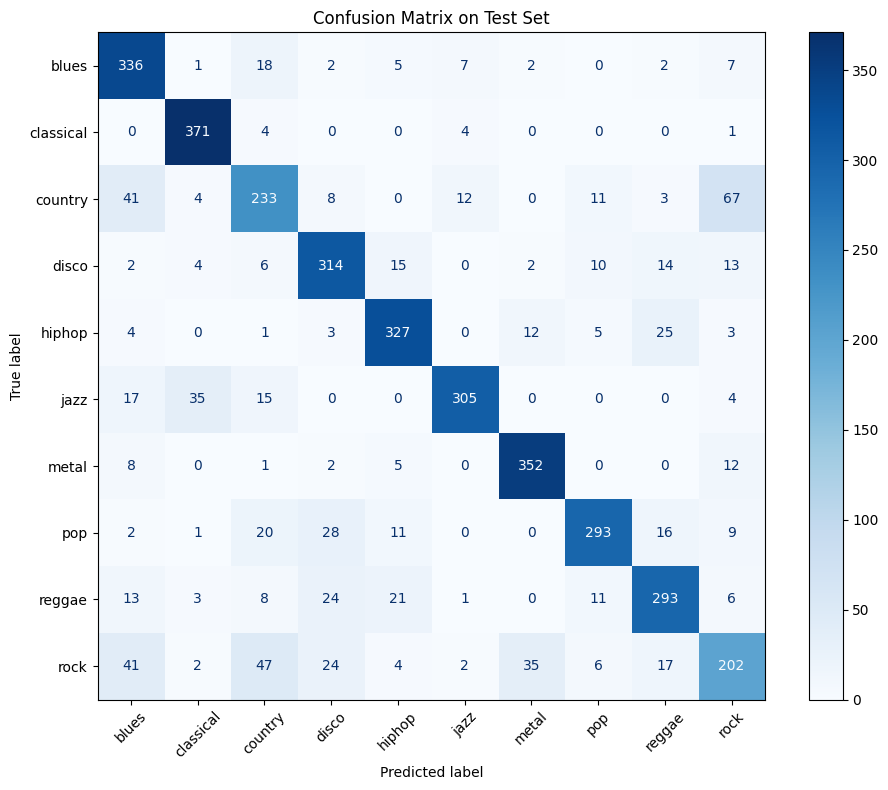

Classification Report:

              precision    recall  f1-score   support

       blues       0.72      0.88      0.80       380
   classical       0.88      0.98      0.93       380
     country       0.66      0.61      0.64       379
       disco       0.78      0.83      0.80       380
      hiphop       0.84      0.86      0.85       380
        jazz       0.92      0.81      0.86       376
       metal       0.87      0.93      0.90       380
         pop       0.87      0.77      0.82       380
      reggae       0.79      0.77      0.78       380
        rock       0.62      0.53      0.57       380

    accuracy                           0.80      3795
   macro avg       0.80      0.80      0.79      3795
weighted avg       0.80      0.80      0.79      3795



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Get model predictions
y_pred_evidence = model.predict(X_test)
y_pred = np.argmax(y_pred_evidence, axis=1)
y_true = y_test

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred, target_names=genres)
print("Classification Report:\n")
print(report)

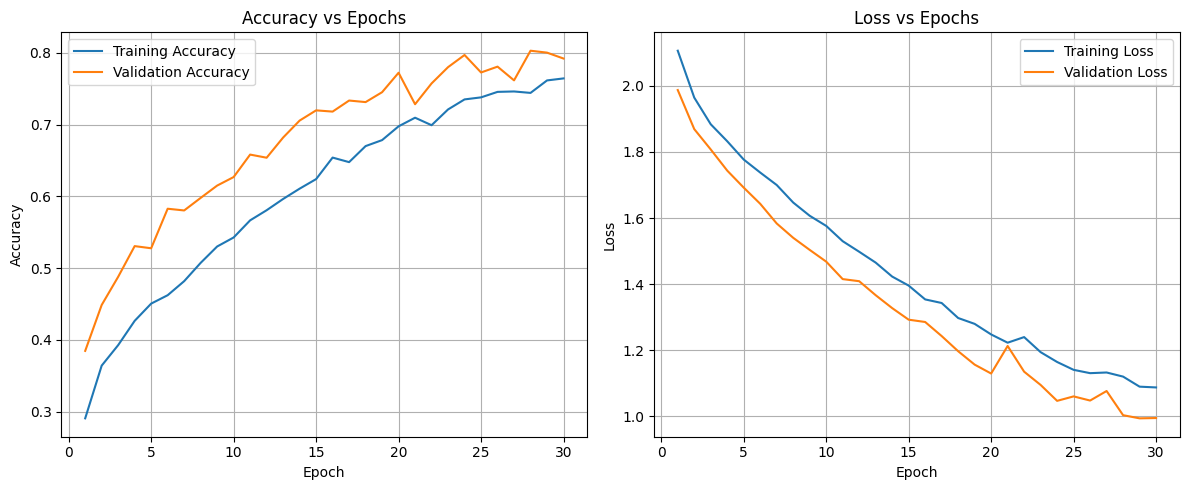

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['edl_accuracy']
val_acc = history.history['val_edl_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def compute_uncertainty(evidence):
    """
    Compute uncertainty from Dirichlet evidence using a small prior.
    evidence: array of shape (num_samples, num_classes)
    Returns: uncertainty score for each sample
    """
    alpha = evidence + 1
    S = np.sum(alpha, axis=1, keepdims=True)
    uncertainty = len(alpha[0]) / S  # Higher means more uncertainty
    return uncertainty.flatten()

In [ ]:
# Predict evidence
evidence = model.predict(X_test)

# Compute uncertainty
uncertainty_scores = compute_uncertainty(evidence)

# Show uncertainty for first 10 test samples
for i in range(10):
    print(f"Sample {i+1} — Uncertainty: {uncertainty_scores[i]:.4f}, True Label: {label_encoder.inverse_transform([y_test[i]])[0]}")

119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
Sample 1 — Uncertainty: 0.3364, True Label: pop
Sample 2 — Uncertainty: 0.2903, True Label: classical
Sample 3 — Uncertainty: 0.5291, True Label: rock
Sample 4 — Uncertainty: 0.3006, True Label: metal
Sample 5 — Uncertainty: 0.5476, True Label: reggae
Sample 6 — Uncertainty: 0.3982, True Label: disco
Sample 7 — Uncertainty: 0.4824, True Label: rock
Sample 8 — Uncertainty: 0.4272, True Label: reggae
Sample 9 — Uncertainty: 0.4527, True Label: rock
Sample 10 — Uncertainty: 0.3471, True Label: hiphop


In [ ]:
threshold = 0.4

# Predicted classes
predicted_classes = np.argmax(evidence, axis=1)

# Flag uncertain predictions
unreliable_mask = uncertainty_scores > threshold
reliable_mask = uncertainty_scores <= threshold

# Print some flagged examples
for i in range(10):
    status = "UNRELIABLE" if unreliable_mask[i] else "reliable"
    print(f"Sample {i+1} — Uncertainty: {uncertainty_scores[i]:.4f}, "
          f"True Label: {label_encoder.inverse_transform([y_test[i]])[0]}, "
          f"Prediction: {label_encoder.inverse_transform([predicted_classes[i]])[0]} — {status}")

Sample 1 — Uncertainty: 0.3364, True Label: pop, Prediction: pop — reliable
Sample 2 — Uncertainty: 0.2903, True Label: classical, Prediction: classical — reliable
Sample 3 — Uncertainty: 0.5291, True Label: rock, Prediction: rock — UNRELIABLE
Sample 4 — Uncertainty: 0.3006, True Label: metal, Prediction: metal — reliable
Sample 5 — Uncertainty: 0.5476, True Label: reggae, Prediction: reggae — UNRELIABLE
Sample 6 — Uncertainty: 0.3982, True Label: disco, Prediction: disco — reliable
Sample 7 — Uncertainty: 0.4824, True Label: rock, Prediction: reggae — UNRELIABLE
Sample 8 — Uncertainty: 0.4272, True Label: reggae, Prediction: reggae — UNRELIABLE
Sample 9 — Uncertainty: 0.4527, True Label: rock, Prediction: rock — UNRELIABLE
Sample 10 — Uncertainty: 0.3471, True Label: hiphop, Prediction: reggae — reliable


In [ ]:
from collections import defaultdict

# Dictionary to store uncertainties per class
class_uncertainties = defaultdict(list)

# Group uncertainties by true label
for i, label in enumerate(y_test):
    class_uncertainties[label].append(uncertainty_scores[i])

# Calculate and print average uncertainty for each class
print("\nAverage uncertainty per class:")
for label in sorted(class_uncertainties.keys()):
    avg_uncertainty = np.mean(class_uncertainties[label])
    class_name = label_encoder.inverse_transform([label])[0]
    print(f"{class_name}: {avg_uncertainty:.4f}")


Average uncertainty per class:
blues: 0.4131
classical: 0.2947
country: 0.4000
disco: 0.4375
hiphop: 0.3702
jazz: 0.4068
metal: 0.3218
pop: 0.3728
reggae: 0.4123
rock: 0.4134


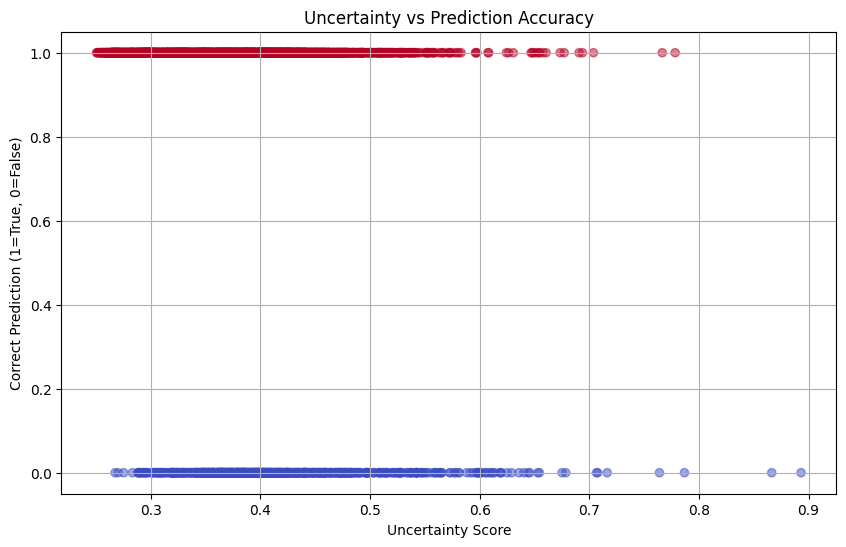

In [ ]:
import matplotlib.pyplot as plt

# Accuracy per sample
correct_predictions = (predicted_classes == y_test)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(uncertainty_scores, correct_predictions, alpha=0.5, c=correct_predictions, cmap='coolwarm')
plt.xlabel("Uncertainty Score")
plt.ylabel("Correct Prediction (1=True, 0=False)")
plt.title("Uncertainty vs Prediction Accuracy")
plt.grid(True)
plt.show()

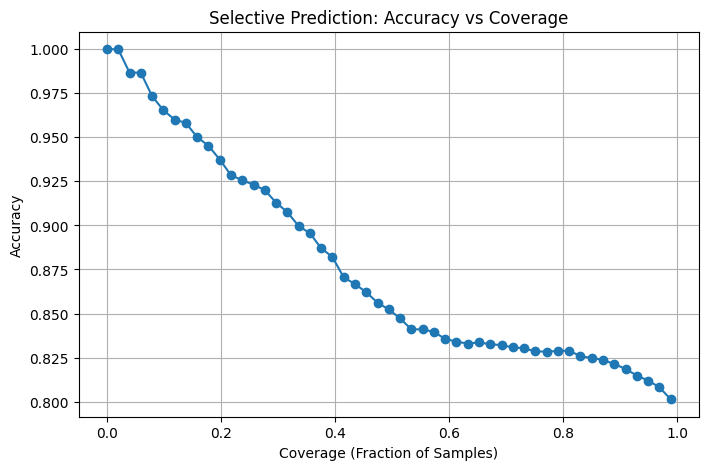

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sort by confidence (i.e., low uncertainty)
sorted_indices = np.argsort(uncertainty_scores)
sorted_uncertainty = uncertainty_scores[sorted_indices]
sorted_preds = predicted_classes[sorted_indices]
sorted_true = y_test[sorted_indices]

# Track coverage (fraction of data retained) and accuracy
coverages = []
accuracies = []

total = len(y_test)

# Iterate over thresholds (from most confident to all)
for k in range(1, total + 1, total // 50):  # 50 points
    selected_preds = sorted_preds[:k]
    selected_true = sorted_true[:k]

    accuracy = np.mean(selected_preds == selected_true)
    coverage = k / total

    coverages.append(coverage)
    accuracies.append(accuracy)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(coverages, accuracies, marker='o')
plt.title("Selective Prediction: Accuracy vs Coverage")
plt.xlabel("Coverage (Fraction of Samples)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [ ]:
def compute_ece(probs, labels, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(np.max(probs, axis=1), bins) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if np.sum(bin_mask) > 0:
            bin_accuracy = np.mean(np.argmax(probs[bin_mask], axis=1) == labels[bin_mask])
            bin_confidence = np.mean(np.max(probs[bin_mask], axis=1))
            ece += (np.sum(bin_mask) / len(labels)) * np.abs(bin_accuracy - bin_confidence)
    return ece

# Convert Dirichlet alpha to probs
alpha = evidence + 1
probs = alpha / np.sum(alpha, axis=1, keepdims=True)
ece_score = compute_ece(probs, y_test)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

Expected Calibration Error (ECE): 0.2918


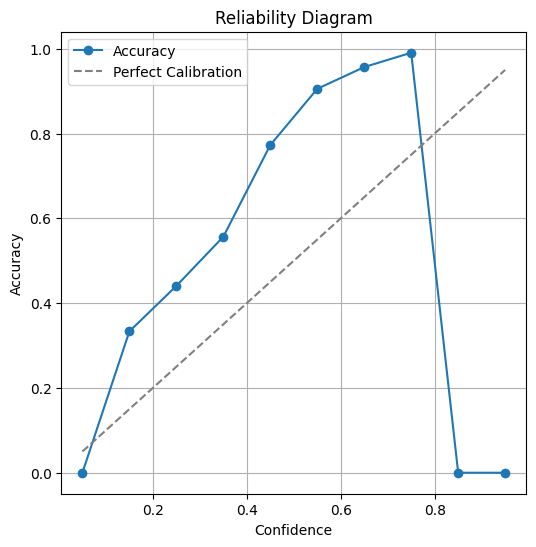

In [ ]:
def plot_reliability_diagram(probs, labels, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    accuracies = []
    confidences = []
    bin_centers = (bins[:-1] + bins[1:]) / 2

    for i in range(n_bins):
        mask = (np.max(probs, axis=1) > bins[i]) & (np.max(probs, axis=1) <= bins[i+1])
        if np.any(mask):
            acc = np.mean(np.argmax(probs[mask], axis=1) == labels[mask])
            conf = np.mean(np.max(probs[mask], axis=1))
            accuracies.append(acc)
            confidences.append(conf)
        else:
            accuracies.append(0)
            confidences.append(0)

    plt.figure(figsize=(6, 6))
    plt.plot(bin_centers, accuracies, marker='o', label="Accuracy")
    plt.plot(bin_centers, bin_centers, linestyle='--', color='gray', label="Perfect Calibration")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_reliability_diagram(probs, y_test)

95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
Optimal temperature (ECE-based): 0.5000
Expected Calibration Error (ECE) after temperature scaling: 0.0190


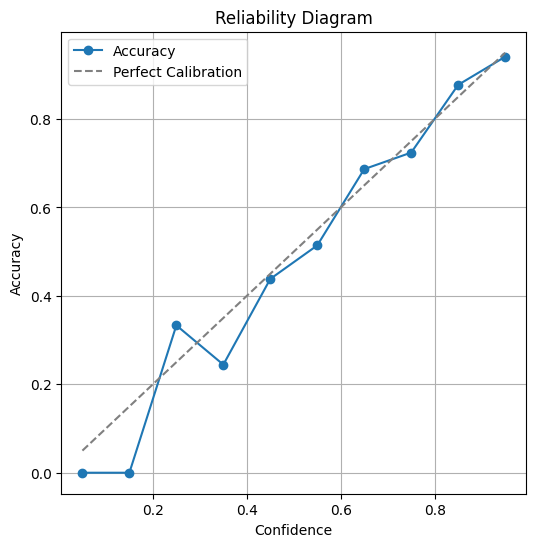

In [ ]:
val_evidence = model.predict(X_val)
val_probs = val_evidence + 1
val_probs /= np.sum(val_probs, axis=1, keepdims=True)

def temperature_scale(probs, temperature):
    logits = np.log(probs + 1e-12)
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
from scipy.optimize import minimize_scalar

def ece_loss(temp, val_probs, val_labels):
    scaled_probs = temperature_scale(val_probs, temp)
    return compute_ece(scaled_probs, val_labels)
res = minimize_scalar(
    lambda t: ece_loss(t, val_probs, y_val),
    bounds=(0.5, 5.0),
    method='bounded'
)

optimal_temp = res.x
print(f"Optimal temperature (ECE-based): {optimal_temp:.4f}")
test_calibrated_probs = temperature_scale(probs, optimal_temp)
ece_score_calibrated = compute_ece(test_calibrated_probs, y_test)
print(f"Expected Calibration Error (ECE) after temperature scaling: {ece_score_calibrated:.4f}")
plot_reliability_diagram(test_calibrated_probs, y_test)


In [ ]:
calibrated_uncertainty_scores = 1 - np.max(test_calibrated_probs, axis=1)
threshold = 0.4
predicted_classes = np.argmax(evidence, axis=1)
unreliable_mask = calibrated_uncertainty_scores > threshold
reliable_mask = calibrated_uncertainty_scores <= threshold

# Print some flagged examples after improvement
for i in range(10):
    status = "UNRELIABLE" if unreliable_mask[i] else "reliable"
    print(f"Sample {i+1} — Uncertainty: {uncertainty_scores[i]:.4f}, "
          f"True Label: {label_encoder.inverse_transform([y_test[i]])[0]}, "
          f"Prediction: {label_encoder.inverse_transform([predicted_classes[i]])[0]} — {status}")

Sample 1 — Uncertainty: 0.3364, True Label: pop, Prediction: pop — reliable
Sample 2 — Uncertainty: 0.2903, True Label: classical, Prediction: classical — reliable
Sample 3 — Uncertainty: 0.5291, True Label: rock, Prediction: rock — reliable
Sample 4 — Uncertainty: 0.3006, True Label: metal, Prediction: metal — reliable
Sample 5 — Uncertainty: 0.5476, True Label: reggae, Prediction: reggae — reliable
Sample 6 — Uncertainty: 0.3982, True Label: disco, Prediction: disco — reliable
Sample 7 — Uncertainty: 0.4824, True Label: rock, Prediction: reggae — reliable
Sample 8 — Uncertainty: 0.4272, True Label: reggae, Prediction: reggae — reliable
Sample 9 — Uncertainty: 0.4527, True Label: rock, Prediction: rock — reliable
Sample 10 — Uncertainty: 0.3471, True Label: hiphop, Prediction: reggae — reliable


In [ ]:
# Dictionary to store calibrated uncertainties per class
class_uncertainties_calibrated = defaultdict(list)

    # Group uncertainties by true label using calibrated scores
for i, label in enumerate(y_test):
        class_uncertainties_calibrated[label].append(calibrated_uncertainty_scores[i])

print("\nAverage calibrated uncertainty per class:")
for label in sorted(class_uncertainties_calibrated.keys()):
          avg_uncertainty_calibrated = np.mean(class_uncertainties_calibrated[label])
          class_name = label_encoder.inverse_transform([label])[0]
          print(f"{class_name}: {avg_uncertainty_calibrated:.4f}")


Average calibrated uncertainty per class:
blues: 0.2398
classical: 0.1147
country: 0.3669
disco: 0.1363
hiphop: 0.1843
jazz: 0.1739
metal: 0.0779
pop: 0.1354
reggae: 0.2175
rock: 0.3230


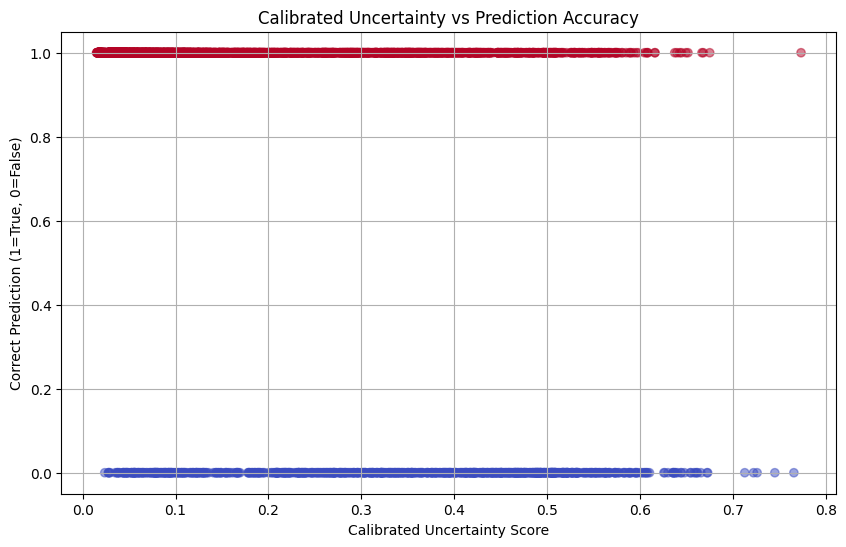

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(calibrated_uncertainty_scores, correct_predictions, alpha=0.5, c=correct_predictions, cmap='coolwarm')
plt.xlabel("Calibrated Uncertainty Score")
plt.ylabel("Correct Prediction (1=True, 0=False)")
plt.title("Calibrated Uncertainty vs Prediction Accuracy")
plt.grid(True)
plt.show()

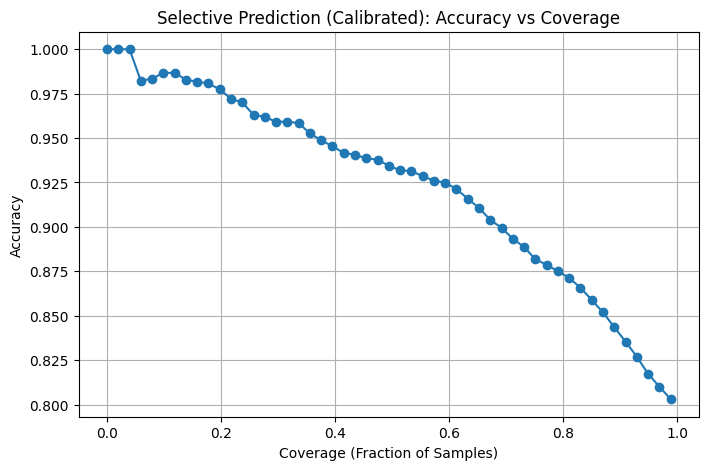

In [ ]:
# Sort by confidence (i.e., low calibrated uncertainty)
sorted_indices_calibrated = np.argsort(calibrated_uncertainty_scores)
sorted_uncertainty_calibrated = calibrated_uncertainty_scores[sorted_indices_calibrated]
sorted_preds_calibrated = predicted_classes[sorted_indices_calibrated]
sorted_true_calibrated = y_test[sorted_indices_calibrated]

# Track coverage (fraction of data retained) and accuracy
coverages_calibrated = []
accuracies_calibrated = []
total = len(y_test)

# Iterate over thresholds (from most confident to all)
for k in range(1, total + 1, total // 50):  # 50 points
        selected_preds_calibrated = sorted_preds_calibrated[:k]
        selected_true_calibrated = sorted_true_calibrated[:k]

        accuracy_calibrated = np.mean(selected_preds_calibrated == selected_true_calibrated)
        coverage_calibrated = k / total

        coverages_calibrated.append(coverage_calibrated)
        accuracies_calibrated.append(accuracy_calibrated)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(coverages_calibrated, accuracies_calibrated, marker='o')
plt.title("Selective Prediction (Calibrated): Accuracy vs Coverage")
plt.xlabel("Coverage (Fraction of Samples)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()